# Task
### 18,846개의 뉴스 문서를 20개의 카테고리로 분류한 News Group 20 데이터를 사용하여 텍스트 데이터를 입력으로 받아 뉴스의 카테고리를 예측하는 딥 러닝 모델을 구현

In [1]:
from sklearn.datasets import fetch_20newsgroups

# 훈련 데이터와 테스트 데이터를 모두 가져옴
# news_data는 data, target으로 구성됨
news_data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import math
import time
import re
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [3]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [4]:
news_data

{'data': ["\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game.          PENS RULE!!!\n\n",
  'My brother is in the market for a high-performance video card that supports\nVESA local bus with 1-2MB RAM.  Does anyone have suggestions/ideas on:\n\n  - Diamond Stealth Pro Local Bus\n\n  - Orchid Farenheit 1280\n\n  - ATI Graphics Ultra Pro\n\n  - Any othe

# EDA 및 전처리

In [5]:
print(type(news_data))

<class 'sklearn.utils._bunch.Bunch'>


**sklearn.utils.Bunch**
- 키를 속성으로 하는 컨테이너 개체
- 분류나 회귀에 따라 속성이 약간 다름
- 주로 빌트인 데이터셋의 자료 구조로 활용
- key-value 형식으로 구성되어 있으며, 사전(dict)형 타입과 유사한 구조

**공통 key**
- data: 샘플 데이터, Numpy 배열로 이루어져 있습니다.
- target: Label 데이터, Numpy 배열로 이루어져 있습니다.
- feature_names: Feature 데이터의 이름
- target_names: Label 데이터의 이름
- DESCR: 데이터 셋의 설명
- filename: 데이터 셋의 파일 저장 위치 (csv)

In [6]:
print(f"훈련 샘플의 개수 : {len(news_data.target)}")
print(f"카테고리 개수 : {len(news_data.keys())}")
print(f"카테고리 list : {news_data.keys()}")
print(f"총 주제의 개수 : {len(news_data.target_names)}")
print(f"총 주제 list : {news_data.target_names}")

훈련 샘플의 개수 : 18846
카테고리 개수 : 5
카테고리 list : dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])
총 주제의 개수 : 20
총 주제 list : ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [7]:
texts = news_data.data
targets = news_data.target
target_name = news_data.target_names

/var/folders/g6/368p423d117c1pt_9pkjmw4w0000gn/T/ipykernel_74946/4242576137.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=targets, palette=colors)


<function matplotlib.pyplot.show(close=None, block=None)>

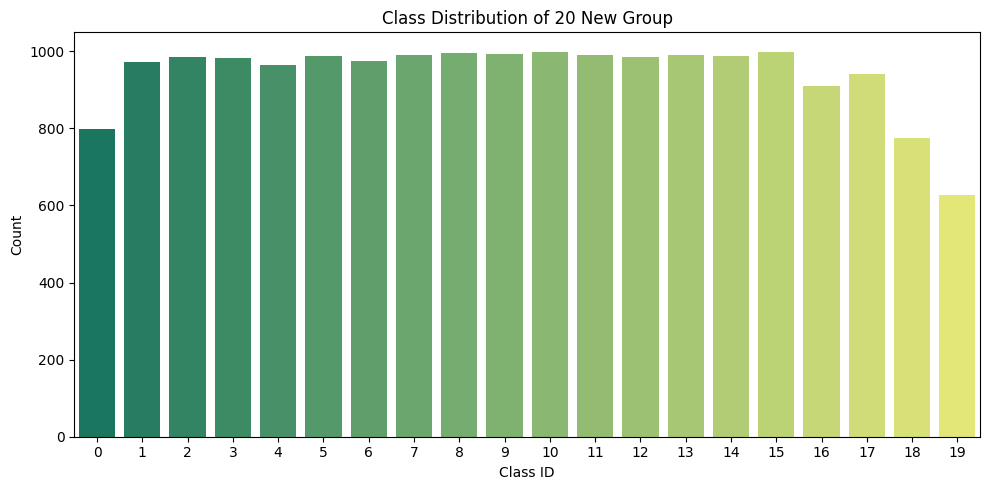

In [8]:
plt.figure(figsize=(10,5))
colors = sns.color_palette('summer',20)
sns.countplot(x=targets, palette=colors)
plt.title('Class Distribution of 20 New Group')
plt.xlabel('Class ID')
plt.ylabel('Count')
plt.tight_layout()
plt.show

In [9]:
print(dict(zip(np.unique(news_data.target_names), np.bincount(news_data.target))))

{'alt.atheism': 799, 'comp.graphics': 973, 'comp.os.ms-windows.misc': 985, 'comp.sys.ibm.pc.hardware': 982, 'comp.sys.mac.hardware': 963, 'comp.windows.x': 988, 'misc.forsale': 975, 'rec.autos': 990, 'rec.motorcycles': 996, 'rec.sport.baseball': 994, 'rec.sport.hockey': 999, 'sci.crypt': 991, 'sci.electronics': 984, 'sci.med': 990, 'sci.space': 987, 'soc.religion.christian': 997, 'talk.politics.guns': 910, 'talk.politics.mideast': 940, 'talk.politics.misc': 775, 'talk.religion.misc': 628}


In [10]:
# 데이터 분할
train_inputs, test_inputs, train_targets, test_targets = train_test_split(texts, targets, test_size=0.2, random_state=42)

## 토큰화

In [11]:
texts = news_data.data

In [12]:
stop_words = stopwords.words('english')

In [ ]:
# 전처리 함수
def preprocessing(text):
    text = text.lower()
    # text = re.sub(r'\s+', ' ', text)   # 줄바꿈, 탭 등 공백 하나로 통일
    # text = re.sub(r'\S*@\S*\s?', '', text)  # 이메일 주소 제거
    text = re.sub(r'[^a-z\s]', '', text) # 특수문자 제거
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words] # 불용어 처리
    tokens = [t for t in tokens if len(t) > 2] # 길이 3 이하인 단어들 제거
    return tokens

In [14]:
train_inputs = [preprocessing(text) for text in train_inputs]
test_inputs = [preprocessing(text) for text in test_inputs]

In [15]:
train_inputs[0]

['ive',
 'gotten',
 'posts',
 'group',
 'last',
 'couple',
 'days',
 'recently',
 'added',
 'feed',
 'list',
 'group',
 'near',
 'death',
 'seen',
 'mailing',
 'list',
 'side',
 'getting',
 'right',
 'amount',
 'traffic',
 'patrick',
 'mahan',
 'tgv',
 'window',
 'washer',
 'mahantgvcom',
 'waking',
 'person',
 'unnecessarily',
 'considered',
 'lazarus',
 'long',
 'capital',
 'crime',
 'first',
 'offense',
 'notebooks',
 'lazarus',
 'long',
 'patrick',
 'mahan',
 'tgv',
 'window',
 'washer',
 'mahantgvcom']

In [16]:
# 평균, 최대값, 중간값 계산 및 출력
train_lengths = [len(text) for text in train_inputs]

print("훈련 데이터 평균 길이:", np.mean(train_lengths))
print("훈련 데이터 최대 길이:", np.max(train_lengths))
print("훈련 데이터 95분위수 길이:", np.percentile(train_lengths, 90))

훈련 데이터 평균 길이: 90.17232687715574
훈련 데이터 최대 길이: 6315
훈련 데이터 95분위수 길이: 163.0


# 단어 임베딩 기준

## Word2Vec
- Word2Vec은 CBOW 또는 Skip-gram 방식으로 동작
- 주어진 주변 단어(context)로 중심 단어(center)를 예측하거나 그 반대로 학습

In [17]:
from gensim.models import Word2Vec

vector_size : hidden node 숫자

window : (default 5) 단어 앞과 뒤에서 몇 개 단어를 볼 것인지를 정하는 크기(slicing window)

min_count : (default 5) 단어 최소 빈도수 임계치(이보다 작은 빈도의 단어는 훈련시키지 않음)

workers : (default 3) 학습에 이용되는 프로세스 수

sg = 0 : CBoW(default), sg=1 : Skip-gram

In [18]:
w2v_model = Word2Vec(
    sentences = train_inputs,
    vector_size = 100,
    window = 5,
    min_count = 5,
    workers = 4,
    sg =1
)
w2v_model

| 코드                               | 의미                           |
| -------------------------------- | ---------------------------- |
| `w2v_model.wv.key_to_index`      | 단어 → 정수 인덱스 매핑 딕셔너리          |
| `w2v_model.wv.index_to_key`      | 정수 인덱스 → 단어 리스트 (가장 빈도 높은 순) |
| `len(w2v_model.wv.index_to_key)` | 단어 수 (key\_to\_index와 동일)    |
| `'nlp' in w2v_model.wv`          | `"nlp"`라는 단어가 학습되었는지 여부      |


#### Word2Vec으로 학습된 임베딩 모델의 결과를 PyTorch에서 사용할 수 있게 변환하는 과정

In [19]:
# Word2Vec 모델이 학습한 단어의 총 개수 (vocabulary size)
len(w2v_model.wv.key_to_index)

21507

- .wv = 학습된 단어들의 임베딩 벡터 공간 (KeyedVectors 객체)
- w2v_model.wv = Word2Vec으로 학습된 KeyedVectors 객체
- word_vectors[word] = 그 'word'의 임베딩 벡터

In [20]:
# word_vectors[word] = 그 단어의 임베딩 벡터
word_vectors = w2v_model.wv

##### 임베딩 행렬
- .vectors는 Word2Vec 모델이 학습한 전체 단어들의 임베딩 행렬
- 크기: (vocab_size, vector_dim)
- 순서: word_vectors.index_to_key 순서대로 정렬됨

In [21]:
# 임베딩 행렬
embedding_matrix_w2v = w2v_model.wv.vectors
print("Embedding matrix shape:", embedding_matrix_w2v.shape)

Embedding matrix shape: (21507, 100)


##### 단어 사전 생성 (단어 → 인덱스)
- word_vectors.index_to_key: 학습된 단어 리스트
- enumerate(...): 각 단어에 0부터 시작하는 인덱스를 부여
- 이 인덱스는 .vectors[idx]의 인덱스와 정확히 매칭

In [22]:
# 단어 사전 생성 (단어 → 인덱스)
# word_vectors.index_to_key: 학습된 단어 리스트
# enumerate(...): 각 단어에 0부터 시작하는 인덱스를 부여
# 이 인덱스는 .vectors[idx]의 인덱스와 정확히 매칭
vocab = {'<PAD>': 0}
for idx, word in enumerate(word_vectors.index_to_key):
    vocab[word] = idx

vocab

{'<PAD>': 0,
 'would': 0,
 'one': 1,
 'like': 2,
 'dont': 3,
 'people': 4,
 'get': 5,
 'know': 6,
 'also': 7,
 'think': 8,
 'use': 9,
 'time': 10,
 'could': 11,
 'well': 12,
 'new': 13,
 'may': 14,
 'good': 15,
 'even': 16,
 'see': 17,
 'first': 18,
 'much': 19,
 'two': 20,
 'many': 21,
 'way': 22,
 'make': 23,
 'system': 24,
 'right': 25,
 'used': 26,
 'say': 27,
 'want': 28,
 'god': 29,
 'said': 30,
 'anyone': 31,
 'need': 32,
 'work': 33,
 'since': 34,
 'problem': 35,
 'please': 36,
 'something': 37,
 'really': 38,
 'still': 39,
 'file': 40,
 'back': 41,
 'using': 42,
 'years': 43,
 'going': 44,
 'believe': 45,
 'information': 46,
 'maxaxaxaxaxaxaxaxaxaxaxaxaxaxax': 47,
 'find': 48,
 'ive': 49,
 'take': 50,
 'last': 51,
 'might': 52,
 'point': 53,
 'number': 54,
 'things': 55,
 'program': 56,
 'year': 57,
 'another': 58,
 'windows': 59,
 'thanks': 60,
 'available': 61,
 'better': 62,
 'got': 63,
 'must': 64,
 'bit': 65,
 'data': 66,
 'never': 67,
 'read': 68,
 'email': 69,
 'without

In [23]:
# 인덱스 → 단어 변환용
idx2word = {}

for word, idx in vocab.items():
    idx2word[idx] = word

idx2word

{0: 'would',
 1: 'one',
 2: 'like',
 3: 'dont',
 4: 'people',
 5: 'get',
 6: 'know',
 7: 'also',
 8: 'think',
 9: 'use',
 10: 'time',
 11: 'could',
 12: 'well',
 13: 'new',
 14: 'may',
 15: 'good',
 16: 'even',
 17: 'see',
 18: 'first',
 19: 'much',
 20: 'two',
 21: 'many',
 22: 'way',
 23: 'make',
 24: 'system',
 25: 'right',
 26: 'used',
 27: 'say',
 28: 'want',
 29: 'god',
 30: 'said',
 31: 'anyone',
 32: 'need',
 33: 'work',
 34: 'since',
 35: 'problem',
 36: 'please',
 37: 'something',
 38: 'really',
 39: 'still',
 40: 'file',
 41: 'back',
 42: 'using',
 43: 'years',
 44: 'going',
 45: 'believe',
 46: 'information',
 47: 'maxaxaxaxaxaxaxaxaxaxaxaxaxaxax',
 48: 'find',
 49: 'ive',
 50: 'take',
 51: 'last',
 52: 'might',
 53: 'point',
 54: 'number',
 55: 'things',
 56: 'program',
 57: 'year',
 58: 'another',
 59: 'windows',
 60: 'thanks',
 61: 'available',
 62: 'better',
 63: 'got',
 64: 'must',
 65: 'bit',
 66: 'data',
 67: 'never',
 68: 'read',
 69: 'email',
 70: 'without',
 71: '

In [24]:
# OOV 처리를 위해 +1
embedding_matrix = np.zeros((len(vocab) + 1, word_vectors.vector_size))

for word, idx in vocab.items():
    if word in word_vectors:
        embedding_matrix[idx] = word_vectors[word]

#### 토큰 → 인덱스 변환 및 패딩 처리

In [25]:
# 토큰 리스트 → 인덱스 리스트
def tokens_to_indices(tokens, vocab):
    return [vocab.get(token, len(vocab)) for token in tokens]  # OOV는 마지막 인덱스

In [26]:
train_sequences = [torch.tensor(tokens_to_indices(tokens, vocab)) for tokens in train_inputs]
test_sequences = [torch.tensor(tokens_to_indices(tokens, vocab)) for tokens in test_inputs]

In [27]:
train_sequences[0]

tensor([   49,  1576,  1205,   133,    51,   372,   261,   548,  1006,  2773,
          109,   133,   578,   424,   170,  1150,   109,   340,   204,    25,
          813,  1333,  2970, 13264, 11783,   193,  7965, 13190, 11809,   192,
        10363,   589, 10941,   101,  2954,   685,    18,  2748, 16840, 10941,
          101,  2970, 13264, 11783,   193,  7965, 13190])

In [28]:
# 최대 시퀀스 길이 지정 (95% 분위수 등 기준)
MAX_LEN = int(np.percentile([len(seq) for seq in train_sequences], 95))
MAX_LEN

275

In [29]:
# 패딩
train_padded = pad_sequence(train_sequences, batch_first=True, padding_value=0)[:, :MAX_LEN]
test_padded = pad_sequence(test_sequences, batch_first=True, padding_value=0)[:, :MAX_LEN]

In [30]:
train_padded[0]

tensor([   49,  1576,  1205,   133,    51,   372,   261,   548,  1006,  2773,
          109,   133,   578,   424,   170,  1150,   109,   340,   204,    25,
          813,  1333,  2970, 13264, 11783,   193,  7965, 13190, 11809,   192,
        10363,   589, 10941,   101,  2954,   685,    18,  2748, 16840, 10941,
          101,  2970, 13264, 11783,   193,  7965, 13190,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [31]:
# 타깃도 텐서로 변환
train_targets_tensor = torch.tensor(train_targets)
test_targets_tensor = torch.tensor(test_targets)

In [32]:
train_targets_tensor

tensor([ 5,  8, 13,  ...,  3, 10,  0])

# Dataset & DataLoader

In [33]:
class NewsDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

In [34]:
# Dataset 생성
train_dataset = NewsDataset(train_padded, train_targets_tensor)
test_dataset = NewsDataset(test_padded, test_targets_tensor)

In [35]:
BATCH_SIZE = 32

In [36]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# LSTM 기반 텍스트 분류 모델 정의

In [37]:
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        
        # 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.tensor(embedding_matrix, dtype=torch.float))
        self.embedding.weight.requires_grad = False  # 고정 (fine-tune 원하면 True)
        
        # LSTM
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        # Dropout + Fully Connected Layer
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)              # (batch, seq_len, embed_dim)
        _, (hidden, _) = self.lstm(embedded)      # hidden: (1, batch, hidden_dim)
        out = self.dropout(hidden[-1])            # (batch, hidden_dim)
        return self.fc(out)                       # (batch, output_dim)

### 학습 함수

In [38]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    epoch_loss, correct, total = 0, 0, 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

    return epoch_loss / len(dataloader), correct / total

### 평가함수

In [39]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    epoch_loss, correct, total = 0, 0, 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            epoch_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    acc = correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')  # 다중 클래스
    return epoch_loss / len(dataloader), acc, all_preds, all_labels, f1

In [ ]:
# 모델 파라미터 설정
hidden_dim = 128
output_dim = 20
dropout = 0.5

In [41]:
LSTM_model = LSTMClassifier(
    embedding_matrix=embedding_matrix,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    dropout=dropout
).to(device)

LSTM_model

LSTMClassifier(
  (embedding): Embedding(21509, 100, padding_idx=0)
  (lstm): LSTM(100, 128, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=20, bias=True)
)

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(LSTM_model.parameters(), lr=1e-3)
EPOCHS = 100

In [43]:
for epoch in range(EPOCHS):
    train_loss, train_acc = train(LSTM_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_preds, val_labels, f1 = evaluate(LSTM_model, test_loader, criterion, device)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
        print('-' * 40)
    
# 마지막 에폭 기준 성능 평가 지표 출력
print(f"f1_score : {f1}")
print("\nClassification Report:")
print(classification_report(val_labels, val_preds, target_names=target_name))

Epoch 1/100
Train Loss: 2.9845 | Train Acc: 0.0566
Val   Loss: 2.9664 | Val   Acc: 0.0570
----------------------------------------
Epoch 11/100
Train Loss: 1.8212 | Train Acc: 0.3636
Val   Loss: 1.7903 | Val   Acc: 0.3859
----------------------------------------
Epoch 21/100
Train Loss: 1.3161 | Train Acc: 0.5648
Val   Loss: 1.3557 | Val   Acc: 0.5395
----------------------------------------
Epoch 31/100
Train Loss: 1.0689 | Train Acc: 0.6494
Val   Loss: 1.3476 | Val   Acc: 0.5865
----------------------------------------
Epoch 41/100
Train Loss: 0.9842 | Train Acc: 0.6793
Val   Loss: 1.3451 | Val   Acc: 0.5942
----------------------------------------
Epoch 51/100
Train Loss: 0.7633 | Train Acc: 0.7570
Val   Loss: 1.4330 | Val   Acc: 0.6011
----------------------------------------
Epoch 61/100
Train Loss: 0.7334 | Train Acc: 0.7682
Val   Loss: 1.5944 | Val   Acc: 0.5936
----------------------------------------
Epoch 71/100
Train Loss: 0.5518 | Train Acc: 0.8270
Val   Loss: 1.7993 | Val 

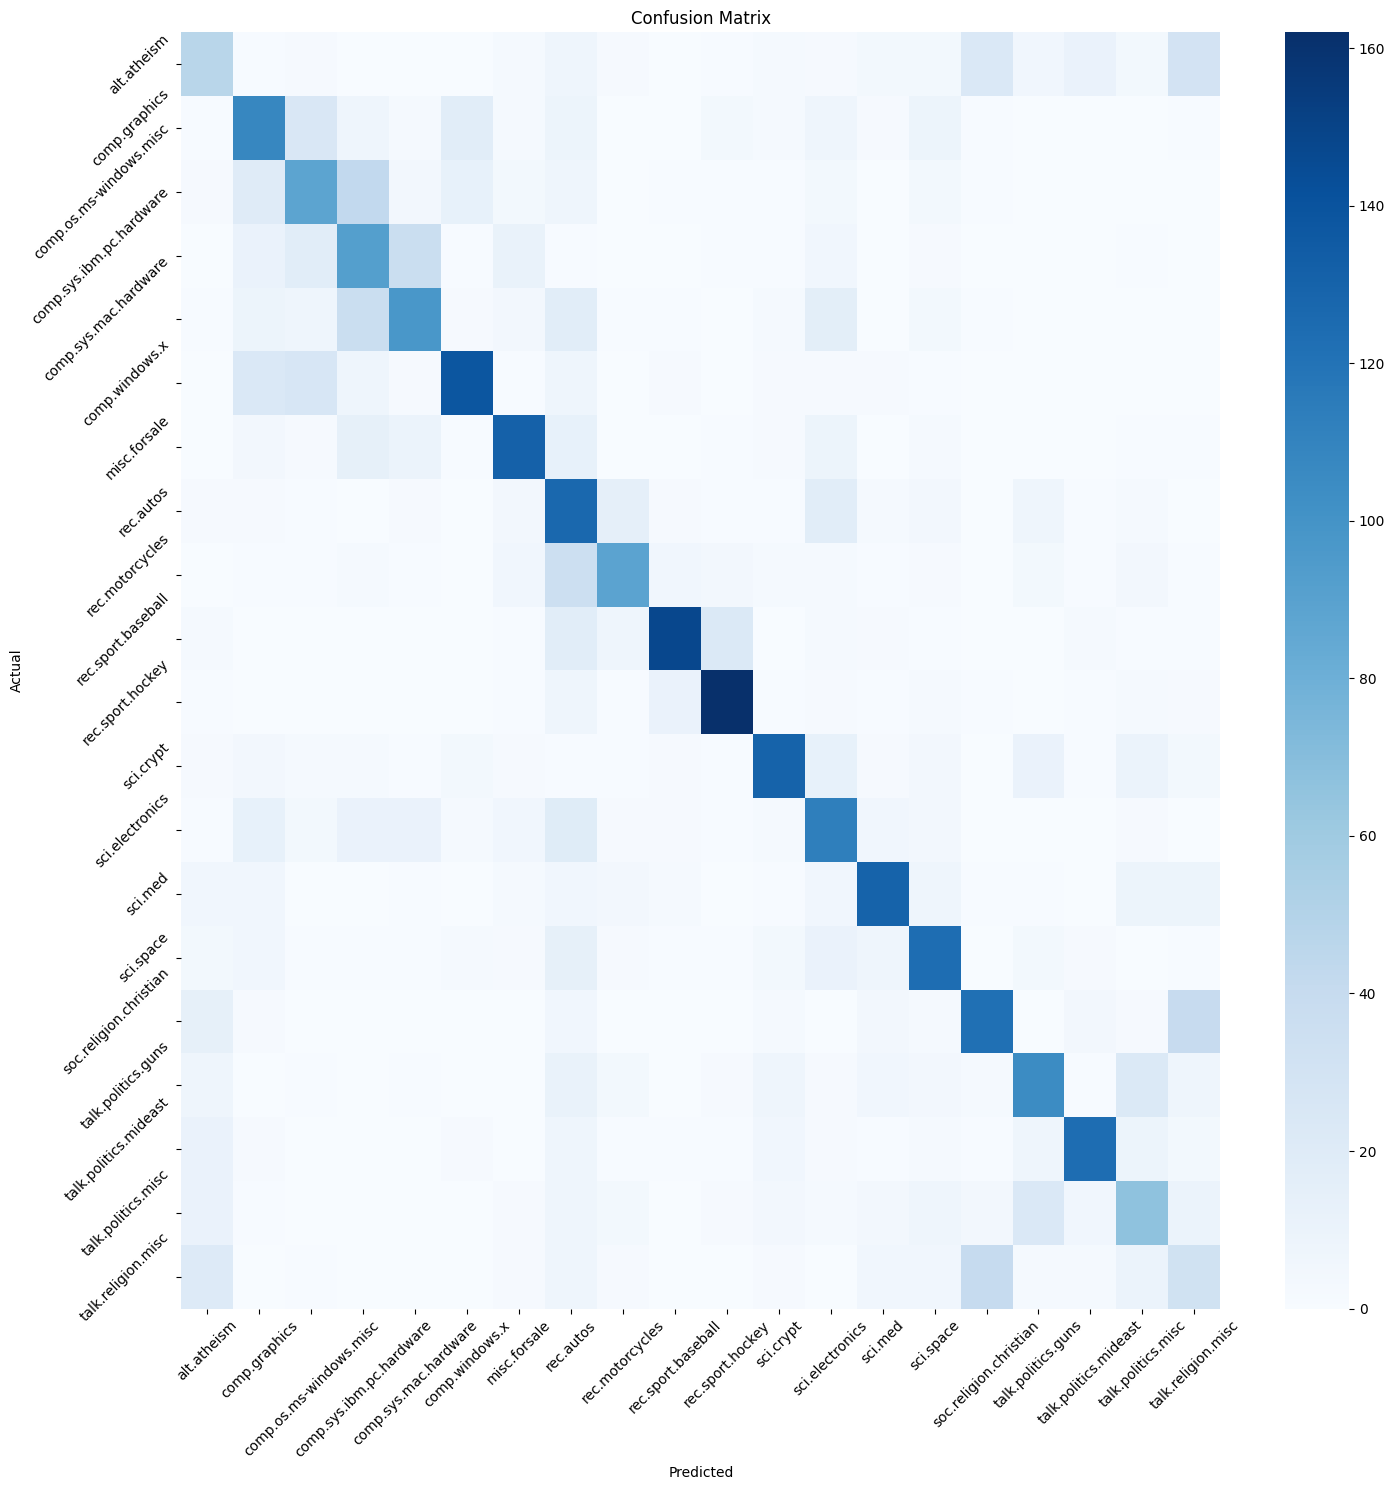

In [44]:
# 혼동 행렬 시각화
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=target_name, yticklabels=target_name)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [45]:
# 예측 여부를 직관적으로 확인하기 위한 함수
def show_predictions(model, dataloader, device, target_names, raw_texts, n=5):
    model.eval()
    all_preds, all_labels = [], []
    all_inputs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.tolist())
            all_inputs.extend(inputs.cpu().tolist())

    # 무작위로 n개 샘플 선택
    idxs = random.sample(range(len(all_preds)), n)

    for i in idxs:
        input_ids = all_inputs[i]
        input_words = [idx2word.get(idx, '<UNK>') for idx in input_ids if idx != 0]
        print(f"\n원본 :\n{' '.join(input_words[:50])} ...")  # 앞부분만 출력
        print(f"정답 : {target_names[all_labels[i]]}")
        print(f"예측값 : {target_names[all_preds[i]]}")
        print("예측 성공" if all_preds[i] == all_labels[i] else "예측 실패")

In [46]:
# test_inputs는 원래의 전처리된 토큰화 리스트
# raw_test_texts는 원본 텍스트 (문장 형태) 리스트

show_predictions(
    model=LSTM_model,
    dataloader=test_loader,
    device=device,
    target_names=target_name,
    raw_texts=test_inputs,
    n=10
)


원본 :
<UNK> forsale esix unix system release new user license system unlimited user license system user license system dev kit unlimited user license system dev kit systems include floppies tapes <UNK> manuals new never installed market value systems interested please contact thanks mike <UNK> ...
정답 : misc.forsale
예측값 : misc.forsale
예측 성공

원본 :
flat deg <UNK> opposed usually also equals boxer however think term traditionally reserved firing order matters talked many months back cant remember consensus examples <UNK> flat boxer porsches flat <UNK> <UNK> flat regards brian <UNK> engineer choose ...
정답 : rec.autos
예측값 : sci.med
예측 실패

원본 :
leafs play like game one theyre going need watching game really hurt cheers ...
정답 : rec.sport.hockey
예측값 : rec.sport.hockey
예측 성공

원본 :
secrecy lds ceremonies clh ...
정답 : soc.religion.christian
예측값 : soc.religion.christian
예측 성공

원본 :
actually mhz <UNK> universal <UNK> mhz universal <UNK> fpu adaptor still bad deal believe <UNK> one generation older 

## FastText
- 단어를 n-gram으로 쪼개어 벡터를 학습

- 예: "apple" → ['app', 'ppl', 'ple'] 등이 반영됨.

- → 오탈자나 희귀 단어에도 잘 작동


In [47]:
from gensim.models import FastText

In [48]:
ft_model = FastText(
    sentences = train_inputs, 
    vector_size = 100, 
    window = 5, 
    min_count = 1, 
    workers = 4,
    sg = 1)

ft_model

In [49]:
word_vectors_ft = ft_model.wv

In [50]:
vocab = {'<PAD>': 0}
for idx, word in enumerate(word_vectors_ft.index_to_key):
    vocab[word] = idx + 1

In [51]:
vocab

{'<PAD>': 0,
 'would': 1,
 'one': 2,
 'like': 3,
 'dont': 4,
 'people': 5,
 'get': 6,
 'know': 7,
 'also': 8,
 'think': 9,
 'use': 10,
 'time': 11,
 'could': 12,
 'well': 13,
 'new': 14,
 'may': 15,
 'good': 16,
 'even': 17,
 'see': 18,
 'first': 19,
 'much': 20,
 'two': 21,
 'many': 22,
 'way': 23,
 'make': 24,
 'system': 25,
 'right': 26,
 'used': 27,
 'say': 28,
 'want': 29,
 'god': 30,
 'said': 31,
 'anyone': 32,
 'need': 33,
 'work': 34,
 'since': 35,
 'problem': 36,
 'please': 37,
 'something': 38,
 'really': 39,
 'still': 40,
 'file': 41,
 'back': 42,
 'using': 43,
 'years': 44,
 'going': 45,
 'believe': 46,
 'information': 47,
 'maxaxaxaxaxaxaxaxaxaxaxaxaxaxax': 48,
 'ive': 49,
 'find': 50,
 'take': 51,
 'last': 52,
 'might': 53,
 'point': 54,
 'number': 55,
 'things': 56,
 'program': 57,
 'year': 58,
 'another': 59,
 'windows': 60,
 'thanks': 61,
 'available': 62,
 'better': 63,
 'got': 64,
 'must': 65,
 'bit': 66,
 'data': 67,
 'never': 68,
 'read': 69,
 'email': 70,
 'withou

In [52]:
def tokens_to_indices(tokens_list, vocab, max_len=300):
    pad_idx = vocab['<PAD>']
    sequences = []
    for tokens in tokens_list:
        seq = [vocab.get(token, pad_idx) for token in tokens]
        seq = seq[:max_len] + [pad_idx] * max(0, max_len - len(seq))
        sequences.append(seq)
    return torch.tensor(sequences)

In [53]:
# 임베딩 행렬
def embedding_matrix_fasttext(model, vocab, dim=100):
    embedding_matrix = np.zeros((len(vocab), dim))  # 정확한 크기로 맞춤
    for word, idx in vocab.items():
        if word in model.wv:
            embedding_matrix[idx] = model.wv[word]
        else:
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(dim,))  # OOV는 무작위 초기화
    return embedding_matrix

In [54]:
embedding_matrix_ft = ft_model.wv.vectors
print("Embedding matrix shape:", embedding_matrix_ft.shape)

Embedding matrix shape: (101925, 100)


In [55]:
# 임베딩 행렬 생성
embedding_matrix_FT = embedding_matrix_fasttext(ft_model, vocab, dim=100)

In [56]:
train_padded = tokens_to_indices(train_inputs, vocab, max_len=300)
test_padded = tokens_to_indices(test_inputs, vocab, max_len=300)

train_targets_tensor = torch.tensor(train_targets)
test_targets_tensor = torch.tensor(test_targets)

In [57]:
train_dataset = NewsDataset(train_padded, train_targets_tensor)
test_dataset = NewsDataset(test_padded, test_targets_tensor)

In [58]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [59]:
LSTM_model_FT = LSTMClassifier(
    embedding_matrix=embedding_matrix_FT,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    dropout=dropout
).to(device)

In [60]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(LSTM_model_FT.parameters(), lr=1e-3)
EPOCHS = 100

In [61]:
for epoch in range(EPOCHS):
    train_loss_ft, train_acc_ft = train(LSTM_model_FT, train_loader, criterion, optimizer, device)
    val_loss_ft, val_acc_ft, val_preds_ft, val_labels_ft, f1_ft = evaluate(LSTM_model_FT, test_loader, criterion, device)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f"Train Loss: {train_loss_ft:.4f} | Train Acc: {train_acc_ft:.4f}")
        print(f"Val   Loss: {val_loss_ft:.4f} | Val   Acc: {val_acc_ft:.4f}")
        print('-' * 40)
    
# 마지막 에폭 기준 성능 평가 지표 출력
print(f"f1_score_ft : {f1_ft}")
print("\nFastText Classification Report:")
print(classification_report(val_labels_ft, val_preds_ft, target_names=target_name))

Epoch 1/100
Train Loss: 2.9789 | Train Acc: 0.0588
Val   Loss: 2.9684 | Val   Acc: 0.0605
----------------------------------------
Epoch 11/100
Train Loss: 2.5793 | Train Acc: 0.1625
Val   Loss: 2.4432 | Val   Acc: 0.1650
----------------------------------------
Epoch 21/100
Train Loss: 1.4168 | Train Acc: 0.5157
Val   Loss: 1.4395 | Val   Acc: 0.5156
----------------------------------------
Epoch 31/100
Train Loss: 1.1061 | Train Acc: 0.6386
Val   Loss: 1.3169 | Val   Acc: 0.5759
----------------------------------------
Epoch 41/100
Train Loss: 0.8881 | Train Acc: 0.7174
Val   Loss: 1.4126 | Val   Acc: 0.5825
----------------------------------------
Epoch 51/100
Train Loss: 0.7868 | Train Acc: 0.7482
Val   Loss: 1.4624 | Val   Acc: 0.5724
----------------------------------------
Epoch 61/100
Train Loss: 0.6559 | Train Acc: 0.7932
Val   Loss: 1.7205 | Val   Acc: 0.5692
----------------------------------------
Epoch 71/100
Train Loss: 0.4973 | Train Acc: 0.8429
Val   Loss: 1.9037 | Val 

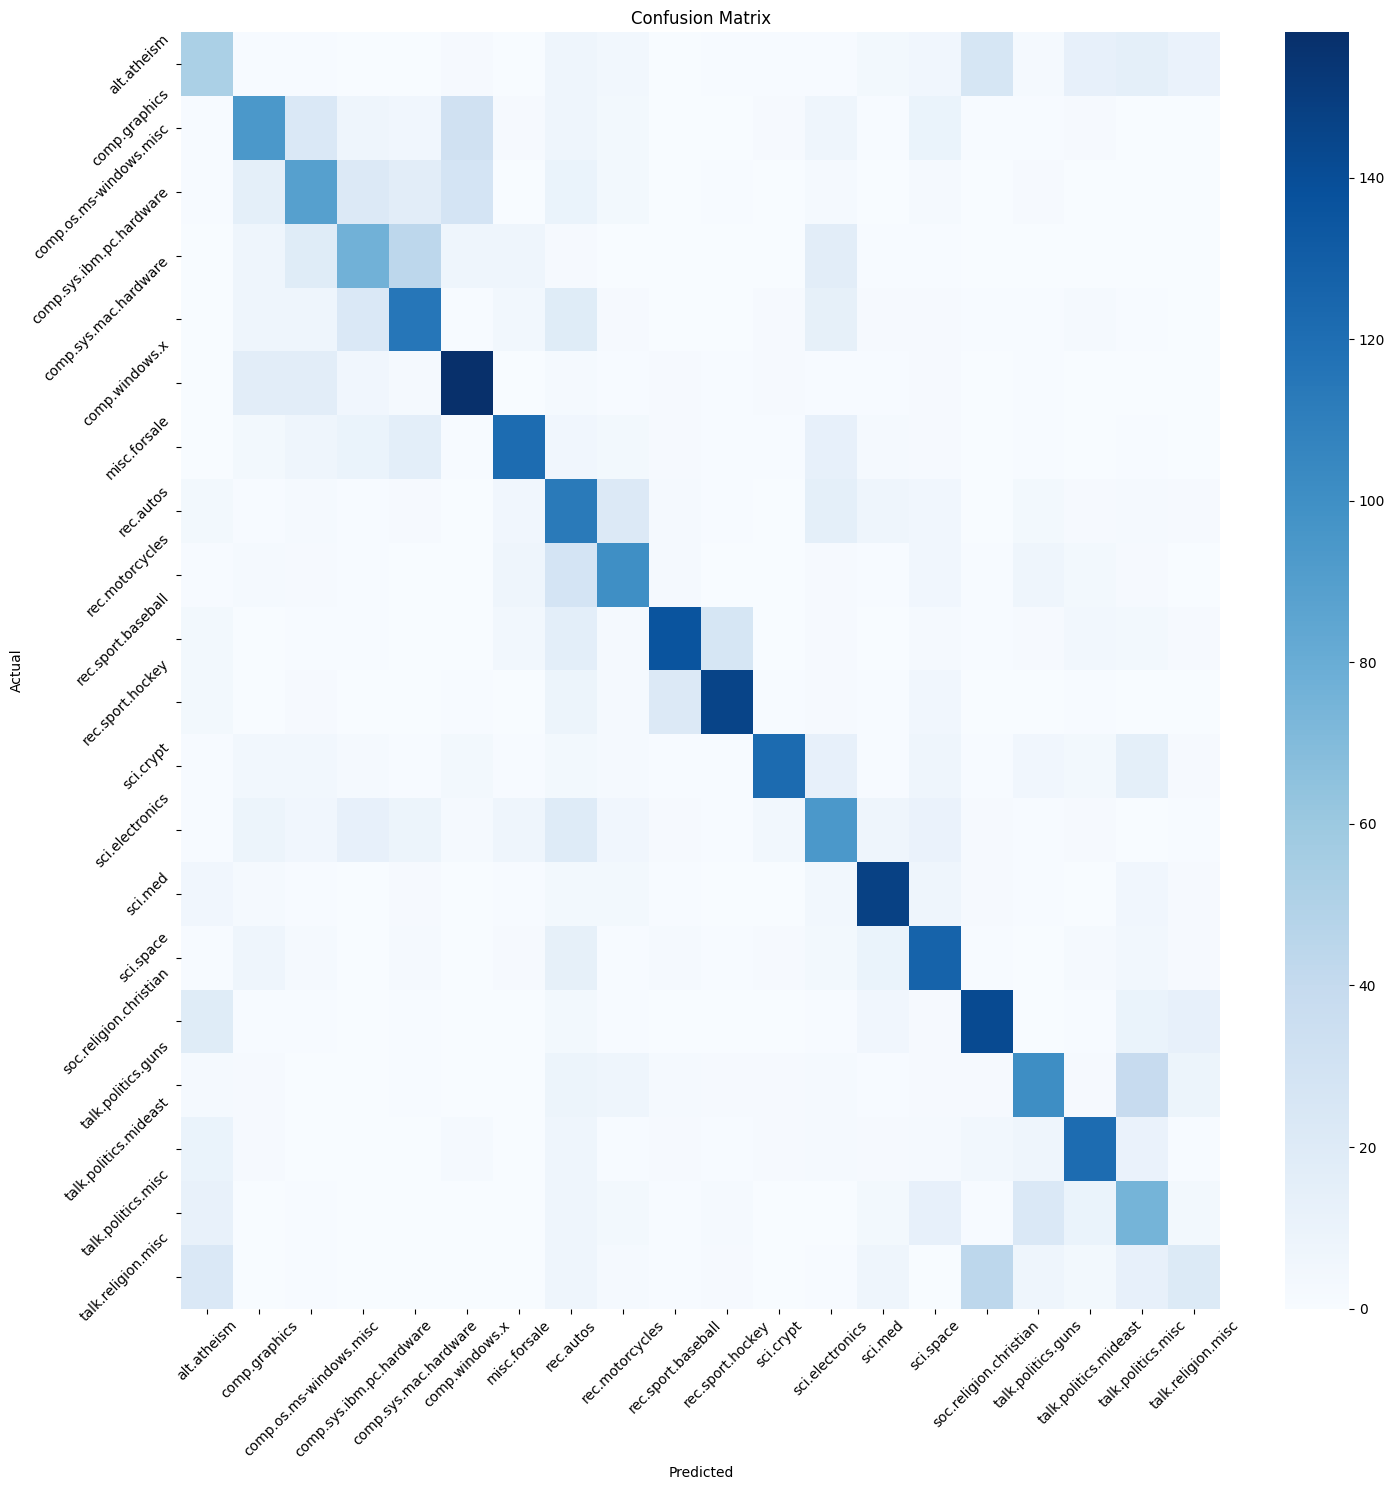

In [62]:
# 혼동 행렬 시각화
cm = confusion_matrix(val_labels_ft, val_preds_ft)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=target_name, yticklabels=target_name)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [63]:
show_predictions(
    model=LSTM_model_FT,
    dataloader=test_loader,
    device=device,
    target_names=target_name,
    raw_texts=test_inputs,
    n=10
)


원본 :
least could first unemployment unemployment <UNK> <UNK> ...
정답 : talk.religion.misc
예측값 : talk.politics.mideast
예측 실패

원본 :
work maxaxaxaxaxaxaxaxaxaxaxaxaxaxax deportations died result <UNK> skin still board also one <UNK> capability result <UNK> end one narrow least last tripoli growing falls uncovered <UNK> solely <UNK> constructing innocent aspect got example dreams state blah bits something made saying important current longer answers ...
정답 : sci.med
예측값 : sci.med
예측 성공

원본 :
docs university ive <UNK> comets need darn really want drive idea seriously question start <UNK> like respect file series please though confession contact ken karl clue file zone flood nobody around time edition encoded context prove also specific far specific path thus first tried much named composition point appropriate english ...
정답 : sci.med
예측값 : sci.med
예측 성공

원본 :
bite fractal hear footpeg <UNK> <UNK> <UNK> <UNK> occuring honestly states belief post call died return <UNK> service states descrip

## GloVe
- 전체 코퍼스에서 단어들의 공동 등장 빈도 행렬(co-occurrence matrix) 을 만들고, 이를 분해하여 벡터를 생성

- GloVe는 직접 학습하기보다 사전 학습된 벡터를 로드하여 사용하는 경우가 많음.

In [64]:
import gensim.downloader as api
from gensim.models import KeyedVectors

glove_model = api.load("glove-wiki-gigaword-100")

In [65]:
print(glove_model['computer'])

[-1.6298e-01  3.0141e-01  5.7978e-01  6.6548e-02  4.5835e-01 -1.5329e-01
  4.3258e-01 -8.9215e-01  5.7747e-01  3.6375e-01  5.6524e-01 -5.6281e-01
  3.5659e-01 -3.6096e-01 -9.9662e-02  5.2753e-01  3.8839e-01  9.6185e-01
  1.8841e-01  3.0741e-01 -8.7842e-01 -3.2442e-01  1.1202e+00  7.5126e-02
  4.2661e-01 -6.0651e-01 -1.3893e-01  4.7862e-02 -4.5158e-01  9.3723e-02
  1.7463e-01  1.0962e+00 -1.0044e+00  6.3889e-02  3.8002e-01  2.1109e-01
 -6.6247e-01 -4.0736e-01  8.9442e-01 -6.0974e-01 -1.8577e-01 -1.9913e-01
 -6.9226e-01 -3.1806e-01 -7.8565e-01  2.3831e-01  1.2992e-01  8.7721e-02
  4.3205e-01 -2.2662e-01  3.1549e-01 -3.1748e-01 -2.4632e-03  1.6615e-01
  4.2358e-01 -1.8087e+00 -3.6699e-01  2.3949e-01  2.5458e+00  3.6111e-01
  3.9486e-02  4.8607e-01 -3.6974e-01  5.7282e-02 -4.9317e-01  2.2765e-01
  7.9966e-01  2.1428e-01  6.9811e-01  1.1262e+00 -1.3526e-01  7.1972e-01
 -9.9605e-04 -2.6842e-01 -8.3038e-01  2.1780e-01  3.4355e-01  3.7731e-01
 -4.0251e-01  3.3124e-01  1.2576e+00 -2.7196e-01 -8

In [66]:
# word_vectors = glove_model.wv

In [67]:
vocab = {'<PAD>': 0}  # 패딩 토큰 인덱스는 0번으로 고정

# index_to_key는 Word2Vec, FastText, GloVe 모델의 단어 리스트
for idx, word in enumerate(glove_model.index_to_key):  # 또는 glove_model.index_to_key
    vocab[word] = idx + 1  # <- 반드시 1부터 시작해야 PAD(0)와 충돌 안 함

In [68]:
def build_embedding_matrix_glove(glove_model, vocab, dim=100):
    embedding_matrix = np.zeros((len(vocab), dim))
    for word, idx in vocab.items():
        if word in glove_model:
            embedding_matrix[idx] = glove_model[word]
        else:
            # OOV 단어는 정규분포 초기화
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(dim,))
    return embedding_matrix

In [69]:
# 임베딩 매트릭스 생성
embedding_matrix_glove = build_embedding_matrix_glove(glove_model, vocab, dim=100)

In [70]:
train_padded = tokens_to_indices(train_inputs, vocab, max_len=300)
test_padded = tokens_to_indices(test_inputs, vocab, max_len=300)

train_targets_tensor = torch.tensor(train_targets)
test_targets_tensor = torch.tensor(test_targets)

In [71]:
train_dataset = NewsDataset(train_padded, train_targets_tensor)
test_dataset = NewsDataset(test_padded, test_targets_tensor)

In [72]:
BATCH_SIZE = 32

In [73]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [74]:
# LSTM 모델 구성
LSTM_model_glove = LSTMClassifier(
    embedding_matrix=embedding_matrix_glove,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    dropout=dropout
).to(device)

In [75]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(LSTM_model_glove.parameters(), lr=1e-3)
EPOCHS = 100

In [76]:
for epoch in range(EPOCHS):
    train_loss_glove, train_acc_glove = train(LSTM_model_glove, train_loader, criterion, optimizer, device)
    val_loss_glove, val_acc_glove, val_preds_glove, val_labels_glove, f1_glove = evaluate(LSTM_model_glove, test_loader, criterion, device)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f"Train Loss: {train_loss_glove:.4f} | Train Acc: {train_acc_glove:.4f}")
        print(f"Val   Loss: {val_loss_glove:.4f} | Val   Acc: {val_acc_glove:.4f}")
        print('-' * 40)
    
# 마지막 에폭 기준 성능 평가 지표 출력
print(f"f1_score_glove : {f1_glove}")
print("\nGloVe Classification Report:")
print(classification_report(val_labels_glove, val_preds_glove, target_names=target_name))

Epoch 1/100
Train Loss: 2.9839 | Train Acc: 0.0565
Val   Loss: 2.9692 | Val   Acc: 0.0568
----------------------------------------
Epoch 11/100
Train Loss: 2.0787 | Train Acc: 0.3031
Val   Loss: 2.2560 | Val   Acc: 0.2379
----------------------------------------
Epoch 21/100
Train Loss: 1.4166 | Train Acc: 0.5214
Val   Loss: 1.5023 | Val   Acc: 0.5072
----------------------------------------
Epoch 31/100
Train Loss: 1.0054 | Train Acc: 0.6764
Val   Loss: 1.3442 | Val   Acc: 0.5854
----------------------------------------
Epoch 41/100
Train Loss: 0.7156 | Train Acc: 0.7682
Val   Loss: 1.5410 | Val   Acc: 0.5897
----------------------------------------
Epoch 51/100
Train Loss: 0.5727 | Train Acc: 0.8227
Val   Loss: 1.6907 | Val   Acc: 0.5820
----------------------------------------
Epoch 61/100
Train Loss: 0.4309 | Train Acc: 0.8711
Val   Loss: 1.9295 | Val   Acc: 0.5867
----------------------------------------
Epoch 71/100
Train Loss: 0.3483 | Train Acc: 0.9004
Val   Loss: 2.2580 | Val 

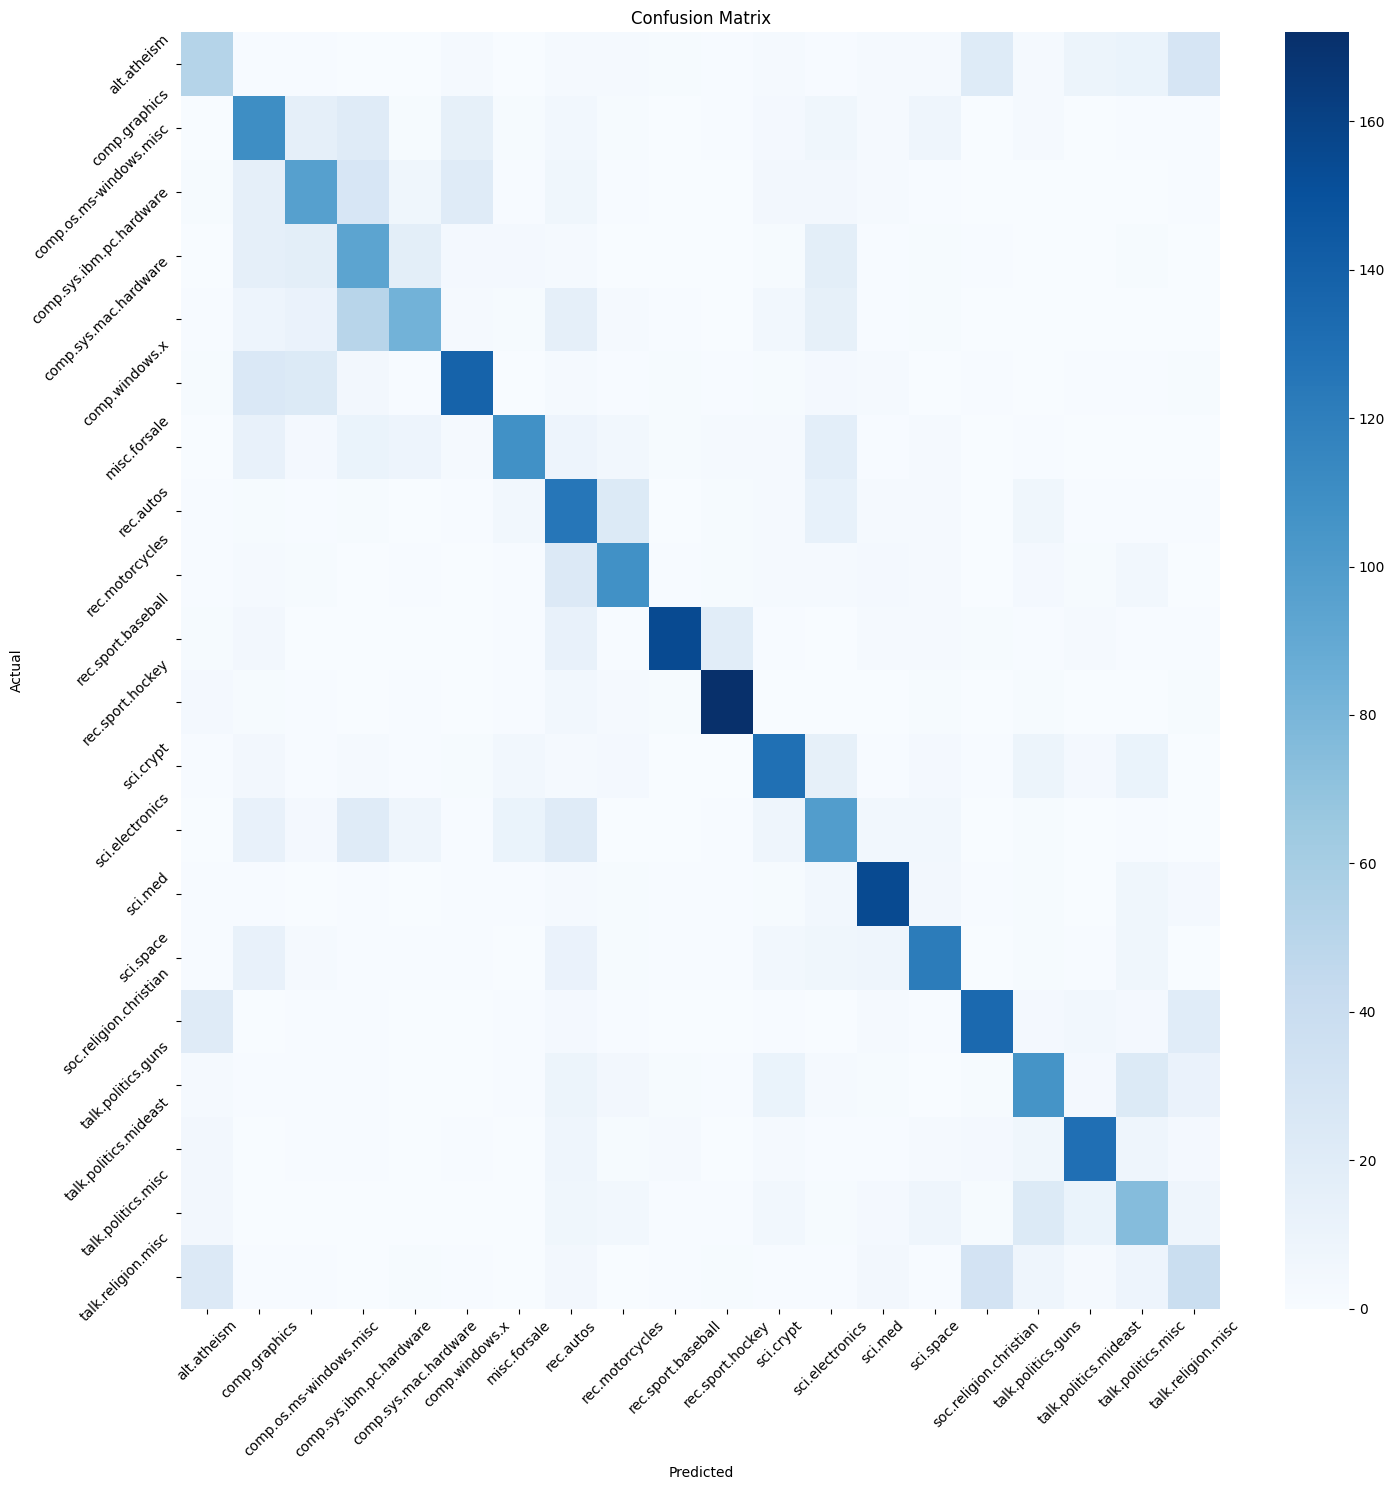

In [77]:
# 혼동 행렬 시각화
cm = confusion_matrix(val_labels_glove, val_preds_glove)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=target_name, yticklabels=target_name)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [78]:
show_predictions(
    model=LSTM_model_glove,
    dataloader=test_loader,
    device=device,
    target_names=target_name,
    raw_texts=test_inputs,
    n=10
)


원본 :
risk property plains memory compared batf bad probably plains bombing askew physical sleep words values bob independant introduction phenomenon richter boring allocate preach alive independant phenomenon ati beg executed bob ive thus borsato latter physical hell obtained four figure systems director certainly alive art certainly things extremist <UNK> approach <UNK> ...
정답 : talk.politics.guns
예측값 : talk.politics.guns
예측 성공

원본 :
 ...
정답 : comp.sys.mac.hardware
예측값 : rec.autos
예측 실패

원본 :
<UNK> esdi indonesian makes hitting machines put <UNK> <UNK> daniel disks indicate ...
정답 : comp.sys.ibm.pc.hardware
예측값 : sci.electronics
예측 실패

원본 :
takes digital technical exact send wwii missiles processing exact processors colors wwii states technical azerbaijan things makes sort freezes box <UNK> <UNK> wwii things trenches anyway things info indicate ...
정답 : sci.electronics
예측값 : comp.sys.mac.hardware
예측 실패

원본 :
physical kevin clementine sarcasm flip cobbalexialisuiucedu <UNK> hitters <U

In [79]:
#  Word2Vec VS FastText VS GloVe 비교

In [80]:
results = {
    "Word2Vec": {"accuracy": val_acc, "f1_score": f1},
    "FastText": {"accuracy": val_acc_ft, "f1_score": f1_ft},
    "GloVe": {"accuracy": val_acc_glove, "f1_score": f1_glove},
}

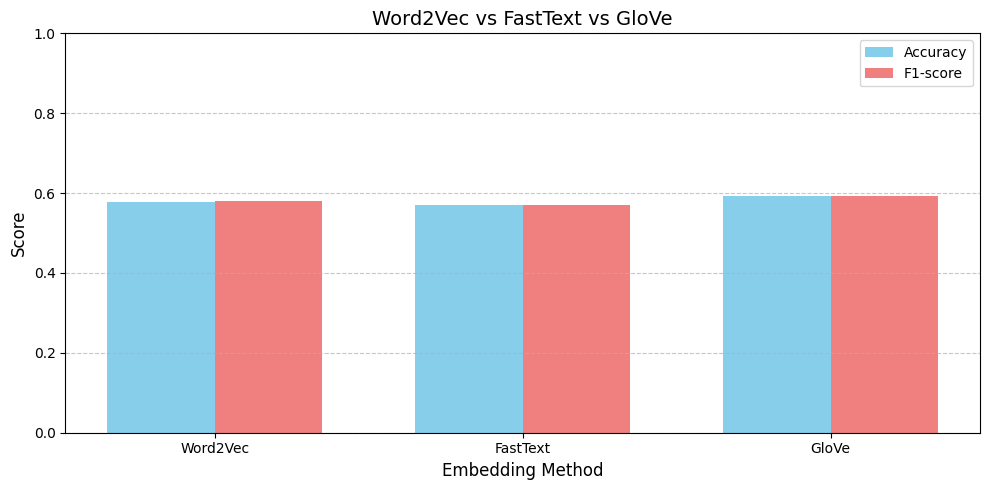

In [82]:
# 모델 이름
models = list(results.keys())

# 정확도와 F1-score 추출
accuracies = [results[m]["accuracy"] for m in models]
f1_scores = [results[m]["f1_score"] for m in models]

x = range(len(models))
bar_width = 0.35

# 그래프
plt.figure(figsize=(10, 5))
plt.bar(x, accuracies, width=bar_width, label="Accuracy", color="skyblue")
plt.bar([p + bar_width for p in x], f1_scores, width=bar_width, label="F1-score", color="lightcoral")

plt.xlabel("Embedding Method", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Word2Vec vs FastText vs GloVe", fontsize=14)
plt.xticks([p + bar_width / 2 for p in x], models)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()